In [208]:
# Имрортируем библиотеку pandas
import pandas as pd

### ОПИСАНИЕ ДАННЫХ

#### **TRAIN.CSV**
-   `row_id`: (int64) ID строки.
-   `timestamp`: (int64) время в миллисекундах между началом сессии пользователя и первым завершением события(задания) этим пользователем.
-   `user_id`: (int32) ID пользователя.
-   `content_id`: (int16) ID контента, с которым взаимодействовал пользователь
-   `content_type_id`: (int8) ID типа контента(0, если событием был вопрос, заданный пользователю, 1, если событием был просмотр лекции)
-   `task_container_id`: (int16) ID блока вопросов или лекций. Например, пользователь может просмотреть три вопроса подряд, прежде чем увидит объяснения к ним. Все эти три вопроса будут иметь общий идентификатор task_container_id.
-   `user_answer`: (int8) ответ пользователя на вопрос, если таковой имеется. -1 - пустое значение для лекций.
-   `answered_correctly`: (int8) Корректность ответа пользователя. Для лекций -1 пустое значение для лекций.
-   `prior_question_elapsed_time`: (float32) Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос в предыдущем пакете вопросов, без учета всех лекций между ними. Пустое значение для первого пакета вопросов или лекции пользователя. Обратите внимание, что время - это среднее время, затраченное пользователем на решение каждого вопроса в предыдущем пакете.
-   `prior_question_had_explanation`: (bool) Увидел ли пользователь объяснение и правильный ответ после ответа на предыдущий пакет вопросов, игнорируя все лекции между ними. Значение является нулевым для первого пакета вопросов или лекции пользователя. Как правило, первые несколько вопросов, которые видит пользователь, были частью диагностического теста при входе в систему, где он не получил никакой обратной связи.


#### **QUESTIONS.CSV**: МЕТАДАННЫЕ ДЛЯ ВОПРОСОВ, ЗАДАВАЕМЫХ ПОЛЬЗОВАТЕЛЯМ.
-   `question_id`: ID вопроса, внешний ключ для столбца content_id в TRAIN.CSV, если тип контента вопрос(0)
-   `bundle_id`: Код, по которому вопросы подаются вместе.
-   `correct_answer`: Правильный ответ на вопрос. Можно сравнить с колонкой user_answer в TRAIN.CSV, чтобы проверить, правильно ли ответил пользователь.
-   `part`: Соответствующий раздел теста TOEIC.
-   `tags`: Один или несколько кодов тегов для вопроса. Смысл тегов не сообщается, но этих кодов достаточно для объединения вопросов в кластеры.

#### **LECTURES.CSV**: МЕТАДАННЫЕ О ЛЕКЦИЯХ, ПРОСМАТРИВАЕМЫХ ПОЛЬЗОВАТЕЛЯМИ ПО МЕРЕ ИХ ОБУЧЕНИЯ.
-   `lecture_id`: ID лекции, внешний ключ для столбца content_id в TRAIN.CSV, если тип контента лекция(1).
-   `part`: код категории верхнего уровня для лекции.
-   `tag`: Код тега для лекции. Значение тегов не приводится, но этих кодов достаточно для объединения лекций в кластеры.
-   `type_of`: Краткое описание основной цели лекции.

In [209]:
# Прочитаем данные из файла lectures.csv и запишем их в lectures.
# Изменим тип данных для минимизации иcпользования памяти
lectures = pd.read_csv('lectures.csv',
                          dtype={'lecture_id': 'int16',
                                 'tag': 'int16',
                                 'part': 'int8',
                                 'type_of': 'category'
                                }
                         )
# Прочитаем данные из файла questions.csv и запишем их в questions.
# Изменим тип данных для минимизации иcпользования памяти
questions = pd.read_csv('questions.csv',
                          dtype={'question_id': 'int16',
                                 'bundle_id': 'int16',
                                 'correct_answer': 'int8',
                                 'part': 'int8',
                                }
                          )
# Прочитаем данные из файла train.csv и запишем их в train.
# Изменим тип данных для минимизации иcпользования памяти
train = pd.read_csv('train.csv',
                       dtype={'row_id': 'int64',
                              'timestamp': 'int64',
                              'user_id': 'int32',
                              'content_id': 'int16',
                              'content_type_id': 'int8',
                              'task_container_id': 'int16',
                              'user_answer': 'int8',
                              'answered_correctly':'int8',
                              'prior_question_elapsed_time': 'float32',
                              'prior_question_had_explanation': 'boolean'
                             }, 
                       index_col=0 # Индексной назначаем колонку с номером 0 из считываемого файла 
                      )

In [210]:
# Выведем информацию о таблице train
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.1 GB


In [211]:
# Выясним количество студентов
train.user_id.nunique()

393656

#### В таблице содержится информация о результатах 393656 студентов

In [255]:
# Выясним количество уникальных вопросов и лекций
train.content_id.nunique()

13782

In [214]:
# Рассмотрим относительноую частоту типов активности: 0 - вопрос(ы), 1 - лекция 
train.content_type_id.value_counts(normalize=True)

content_type_id
0    0.980648
1    0.019352
Name: proportion, dtype: float64

#### более 98% активности студентов приходится на ответы на вопросы
#### менее 2% активности приходится на лекции

In [215]:
# Рассмотрим типы активности в абсолютных значениях: 0 - вопрос(ы), 1 - лекция 
train.content_type_id.value_counts()

content_type_id
0    99271300
1     1959032
Name: count, dtype: int64

#### 99271300 количество ответов на вопросы
#### 1959032 количество просмотров лекций

In [216]:
# Отфильтруем таблицу по ответам на вопросы
train_q=train[train['content_type_id'] == 0]
# Отфильтруем таблицу по лекциям
train_l=train[train['content_type_id'] == 1]

In [217]:
# Найдем количество уникальных вопросов
train_q.content_id.nunique()

13523

In [218]:
# Найдем количество уникальных лекций
train_l.content_id.nunique()

415

In [219]:
# Найдем количество блоков вопросов и лекций
train.task_container_id.nunique()

10000

In [220]:
# Рассмотрим относительноую частоту верных\неверных ответов на вопросы
train_q['answered_correctly'].value_counts(normalize=True) 

answered_correctly
1    0.657236
0    0.342764
Name: proportion, dtype: float64

#### 66% составляют правильные ответы 
#### 34% составляют неправильные ответы 

In [221]:
# Рассмотрим абсолютное количество верных\неверных ответов на вопросы
train_q['answered_correctly'].value_counts() 

answered_correctly
1    65244627
0    34026673
Name: count, dtype: int64

#### 65244627 составляют правильные ответы 
#### 34026673 составляют неправильные ответы 

In [222]:
# Рассмотрим какие ответы наиболее часто встречаются
train_q_answ = train_q[['user_answer', 'answered_correctly']].groupby(['user_answer']).agg(['count'])
# Выведем результат
print(train_q_answ)

            answered_correctly
                         count
user_answer                   
0                     28186489
1                     26990007
2                     18010020
3                     26084784


#### Наиболее частовстречаемый ответ - 0.
#### Наименее частовстречаемый ответ - 2

In [223]:
# отфильтруем таблицу по правильным ответам
train_answ_corr = train_q[train_q.answered_correctly == 1]
# сгруппируем по вопросам и посчитаем количество правильных ответов на вопрос
count_corr = train_answ_corr[['content_id', 'user_answer']].groupby(['content_id']).agg(['count'])
# посмотрим статистику ответов
count_corr.describe()

,user_answer
,count
count,13519.000000
mean,4826.142984
std,6419.895726
min,1.000000
25%,1275.000000
50%,3237.000000
75%,5879.000000
max,149422.000000


#### В таблице 13519 вопросов, имеющих хотя бы один правильный ответ
#### Максимальное число правильных ответов на один вопрос 149422
#### Мнимальное число правильных ответов на один вопрос 1
#### В среднем каждый вопрос имеет 4826 правильных ответов

In [224]:
# отфильтруем таблицу по неправильным ответам
train_answ_incorr = train_q[train_q.answered_correctly == 0]
# сгруппируем по вопросам и посчитаем количество неправильных ответов на вопрос
count_incorr = train_answ_incorr[['content_id', 'user_answer']].groupby(['content_id']).agg(['count'])
# посмотрим статистику ответов
count_incorr.describe()

,user_answer
,count
count,13506.000000
mean,2519.374574
std,6078.817129
min,1.000000
25%,369.250000
50%,1130.000000
75%,2688.500000
max,153992.000000


#### В таблице 13506 вопросов, имеющих хотя бы один неправильный ответ
#### Максимальное число неправильных ответов на один вопрос 153992
#### Мнимальное число неправильных ответов на один вопрос 1
#### В среднем каждый вопрос имеет 2519 неправильных ответов

In [225]:
# Найдем и выведем среднее время ответа на вопрос
print('Cреднее время ответа на вопрос',round(train['prior_question_elapsed_time'].mean()/1000,3),'сек.')

Cреднее время ответа на вопрос 25.424 сек.


### Исследуем, как отражаются увиденные пользователем объяснения и правильный ответ, на количество правильных ответов.

In [226]:
# Cгруппируем таблицу ответов по пользователю и посчитаем количество просмотров пользователем объяснений/ответов
had_explanation_count = train_q[['user_id', 'prior_question_had_explanation']].groupby(['user_id']).agg(['sum']).sort_values(by=['user_id'])
# Обозначим столбец количества просмотров пользователем объяснений/ответов
had_explanation_count.columns = ['explanation_count']
# Выведем первые три строки полученной таблицы
had_explanation_count.head(3)

,explanation_count
user_id,
115,6
124,0
2746,11


In [227]:
# Cгруппируем таблицу правильных ответов по пользователю и посчитаем количество правильных ответов от каждого пользователя
user_correct_answ_count=train_answ_corr[['user_id', 'answered_correctly']].groupby(['user_id']).agg(['count']).sort_values(by=['user_id'])
# Обозначим столбец количества правильных ответов
user_correct_answ_count.columns = ['answered_correctly_count']
# Выведем первые три строки полученной таблицы
user_correct_answ_count.head(3)

,answered_correctly_count
user_id,
115,32
124,7
2746,11


In [228]:
# Объединим таблицы количества правильных ответов и просмотров объяснений/ответов
user_answ_explan_merge = had_explanation_count.merge(user_correct_answ_count, how='left', left_on='user_id', right_on='user_id')
# Выведем первые три строки полученной таблицы
user_answ_explan_merge.head(3)

,explanation_count,answered_correctly_count
user_id,,
115,6,32.0
124,0,7.0
2746,11,11.0


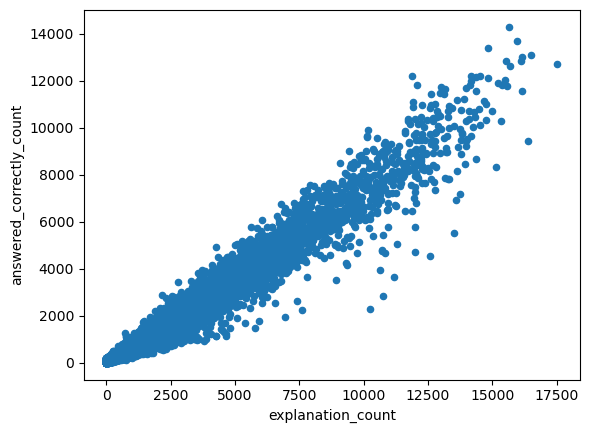

In [229]:
# Построим графих зависимости количества правильных ответов от количества просмотров объяснений/ответов
user_answ_explan_merge.plot(x='explanation_count', y='answered_correctly_count',  kind = 'scatter');

### С увеличением количества просмотров объяснений/ответов наблюдается рост количества правильных ответов

In [230]:
# Выведем информацию о таблице questions
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 185.0+ KB


In [231]:
# Получим количество уникальных вопросов
questions['question_id'].nunique()

13523

In [232]:
# Получим количество уникальных блоков вопросов
questions['bundle_id'].nunique()

9765

In [233]:
# Получим количество вариантов ответа на вопрос
questions['correct_answer'].nunique()

4

In [234]:
# Получим количество разделов в тесте TOEIC, которых присутствуют вопросы из таблицы
questions['part'].nunique()

7

In [235]:
# Получим количество уникльных наборов тегов
questions['tags'].nunique()

1519

In [236]:
# Выведем первые три строки таблицы questions
questions.head(3)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92


In [237]:
# Сгруппируем вопросы по блокам, посчитаем количество вопросов в каждом блоке
quest_bundle = questions[['bundle_id', 'question_id']].groupby(['bundle_id']).agg(['count']).sort_values(by=['bundle_id'])
# Посмотрим статистики
quest_bundle.describe()

,question_id
,count
count,9765.000000
mean,1.384844
std,0.906515
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5.000000


### Втаблице 9765 блоков с вопросами
### В среднем в каждом блоке 1.38 вопроса
### В каждом блоке есть хотя бы один вопрос
### Максимальное количество вопросов в блоке 5

In [238]:
# Сгруппируем вопросы по разделам теста TOEIC, посчитаем количество вопросов в каждом блоке
quest_part = questions[['part', 'question_id']].groupby(['part']).agg(['count']).sort_values(by=['part'])
# Посмотрим статистики
quest_part.describe()

,question_id
,count
count,7.000000
mean,1931.857143
std,1595.221973
min,992.000000
25%,1186.000000
50%,1439.000000
75%,1604.500000
max,5511.000000


In [239]:
# Посмотрим, как распределены вопросы в оттношении теста TOEIC
questions['part'].value_counts(normalize=True)

part
5    0.407528
2    0.121793
3    0.115507
4    0.106411
6    0.089625
7    0.085780
1    0.073357
Name: proportion, dtype: float64

### В таблице присутствуют вопросы из 7 разделов теста TOEIC
### Больше всего вопросов из пятого раздела 5511
### Меньше всего вопросов из первого раздела 992
### В среднем в таблице 1932 вопроса из каждого раздела

In [240]:
# Выясним сколько уникальных тегов содержится в столбце tags
# Создадим пустое множество tags
tags = set()
# Запустим цикл по строкам столбца tags
for tag in questions['tags']:
    try: # Предусмотрим возможную ошибку работы с разделителем
        for t in tag.split(): # Запустим цикл по алементам строки, разделенным между собой пробелом
            tags.add(int(t)) # Добавим элемент в множество
    except: # Если возникла ошибка
        tags.add(int(t)) # Добавим элемент в множество

# Выведем количество уникальных тегов, по которым можно проводить кластеризацию
len(tags)

188

In [241]:
# Добавим к таблице train_q(ответы на вопросы) столбцы из таблицы questions по внешнему ключу
train_quest_merge = train_q.merge(questions, how='left', left_on='content_id', right_on='question_id')
# Выведем три строки полученной таблицы
train_quest_merge.head(3)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,115,5692,0,1,3,1,NaN,<NA>,5692,5692,3,5,151
1,56943,115,5716,0,2,2,1,37000.0,False,5716,5716,2,5,168
2,118363,115,128,0,0,0,1,55000.0,False,128,128,0,1,131 149 92


In [242]:
# Посмотрим как зависит успесаемость студентов от принадлежности вопроса к разным разделам TOEIC
# Создадим таблтцу с количеством правильных ответов по разделам
tq_part_answer = train_quest_merge[['part', 'answered_correctly']].groupby(['part']).agg(['sum']).sort_values(by=['part'])
# Дадим новое имя столбцу
tq_part_answer.columns = ['answered_correctly_count']
# Создадим таблтцу с количеством ответов по разделам
tq_part_quest = train_quest_merge[['part', 'user_answer']].groupby(['part']).agg(['count']).sort_values(by=['part'])
# Дадим новое имя столбцу
tq_part_quest.columns = ['user_answer_count']
# Объединим таблицы вопросов и правильных ответов
tq_part_merge = tq_part_answer.merge(tq_part_quest, left_on='part', right_on='part')
# Расситаем и добавим процент правильных ответов для каждого раздела TOEIC
tq_part_merge = tq_part_merge.assign(correct_percent = tq_part_merge['answered_correctly_count']/tq_part_merge['user_answer_count']*100)
# Посмотрим полученный результат
tq_part_merge.head(7)

,answered_correctly_count,user_answer_count,correct_percent
part,,,
1,5553896,7454570,74.503238
2,13283339,18743404,70.869406
3,6060514,8639907,70.145593
4,5090684,8067676,63.099758
5,24957570,40908153,61.008792
6,7029563,10501472,66.938835
7,3269061,4956118,65.960112


### Судя по количеству правильных ответов задел 1 самый легкий
### Рздел 5 самый трудный
### Начиная с четвертого раздела сложность вопросов увеличилась

In [243]:
# Выведем информацию о таблице lectures
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lecture_id  418 non-null    int16   
 1   tag         418 non-null    int16   
 2   part        418 non-null    int8    
 3   type_of     418 non-null    category
dtypes: category(1), int16(2), int8(1)
memory usage: 2.8 KB


In [244]:
# Получим количество уникальных лекций
lectures['lecture_id'].nunique()

418

In [245]:
# Получим количество уникальных тегов
lectures['tag'].nunique()

151

In [246]:
# Получим количество категорий верхнего уровня для лекций
lectures['part'].nunique()

7

In [247]:
# Получим количество уникальных описаний лекций
lectures['type_of'].nunique()

4

In [248]:
# Выведем первые пять строк таблицы lectures
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [249]:
# Посмотрим описания лекций и их частоты
lectures['type_of'].value_counts(normalize=True)

type_of
concept             0.531100
solving question    0.444976
intention           0.016746
starter             0.007177
Name: proportion, dtype: float64

### 53.1% лекций в таблице имеют описание "concept"
### 44.5% лекций в таблице имеют описание "solving question"
### 1.7% лекций в таблице имеют описание "intention"
### 0.7% лекций в таблице имеют описание "starter"

In [250]:
# Добавим к таблице train_l(лекции) столбцы из таблицы lectures по внешнему ключу
train_lect_merge = train_l.merge(lectures, how='left', left_on='content_id', right_on='lecture_id')
# Выведем три строки полученной таблицы
train_lect_merge.head(3)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,part,type_of
0,653762,2746,6808,1,14,-1,-1,NaN,False,6808,129,2,intention
1,10183847,5382,16736,1,21,-1,-1,NaN,False,16736,40,1,concept
2,1424348597,5382,30207,1,104,-1,-1,NaN,False,30207,43,5,concept


In [251]:
# Посмотрим относительное количество лекцй по категориям
lectures['part'].value_counts(normalize=True)

part
5    0.342105
6    0.198565
2    0.133971
1    0.129187
7    0.076555
4    0.074163
3    0.045455
Name: proportion, dtype: float64

In [252]:
# Сгруппируем просмотры по лекциям и проанализируем их
tl_pop_lect = train_lect_merge[['content_id', 'user_id']].groupby(['content_id']).agg(['count']).sort_values(by=['content_id'])
# Дадим новое имя столбцу
tl_pop_lect.columns = ['number_of_views']
# Посмотрим статистики
tl_pop_lect.describe()

,number_of_views
count,415.000000
mean,4720.559036
std,5275.046378
min,1.000000
25%,1104.000000
50%,2723.000000
75%,6896.500000
max,37024.000000


### Таблица содержит информацию о 415 лекциях, их смотрели хотя бы 1 раз
### 3 лекции из таблицы lectures не смотрели вообще
### Среднее количество просмотров одной лекции 4721
### Максимальное количество просмотров одной лекции 37024

In [253]:
# Сгруппируем просмотры по категориям и проанализируем их
tl_pop_part = train_lect_merge[['part', 'user_id']].groupby(['part']).agg(['count']).sort_values(by=['part'])
# Дадим новое имя столбцу
tl_pop_part.columns = ['number_of_views']
# Посмотрим статистики
tl_pop_part.describe()

,number_of_views
count,7.000000
mean,279861.714286
std,308651.475293
min,57030.000000
25%,96147.500000
50%,173057.000000
75%,300927.500000
max,934795.000000


In [254]:
# Посмотрим относительную частоту просмотров по каждой категории
train_lect_merge['part'].value_counts(normalize=True)

part
5    0.477172
2    0.195060
6    0.112160
1    0.088338
3    0.050646
4    0.047512
7    0.029111
Name: proportion, dtype: float64

### Лекции из категории 5 являются самыми популярными, их смотрели 937795 раз
### Лекции из категории 7 являются самыми непопулярными, их смотрели 57030 раз
### Среднее количество просмотров лекций из одного раздела 279862 раза